# Credit Card Approval Classification (Random Forest)

## Setup

In [1]:
from fastai.imports import *
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import graphviz

sns_palette = sns.color_palette("muted")

In [2]:
%%html
<style>
table {float:left}
</style>

### Data

In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/credit-card-details')
    !pip install -Uqq fastai
else:
    path = Path('./cc_approval')

# credit card csv doesn't have label column, the rows line up so just
# add labels to the df
df = pd.read_csv(path/'Credit_card.csv')
labels = pd.read_csv(path/'Credit_card_label.csv')

dep = 'Approved'

df[dep] = labels.label.astype(int)

df.loc[df[dep] == 1, 'Status'] = 'Approved'
df.loc[df[dep] == 0, 'Status'] = 'Declined'

## Exploring the Data

In [4]:
print('Total records:', len(df))

Total records: 1548


In [5]:
df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Approved,Status
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1,Approved
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,Approved
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1,Approved
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,Approved
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,Approved


In [6]:
df.drop('Ind_ID', axis=1).describe()

,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,Approved
count,1548.000000,1.525000e+03,1526.000000,1548.000000,1548.0,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,0.412791,1.913993e+05,-16040.342071,59364.689922,1.0,0.208010,0.309432,0.092377,2.161499,0.113049
std,0.776691,1.132530e+05,4229.503202,137808.062701,0.0,0.406015,0.462409,0.289651,0.947772,0.316755
min,0.000000,3.375000e+04,-24946.000000,-14887.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.215000e+05,-19553.000000,-3174.500000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,1.665000e+05,-15661.500000,-1565.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,2.250000e+05,-12417.000000,-431.750000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,14.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,15.000000,1.000000


In [7]:
print('Modes')
print('----------------------')
df.drop('Ind_ID', axis=1).mode().iloc[0]

Modes
----------------------


GENDER                                         F
Car_Owner                                      N
Propert_Owner                                  Y
CHILDREN                                     0.0
Annual_income                           135000.0
Type_Income                              Working
EDUCATION          Secondary / secondary special
Marital_status                           Married
Housing_type                   House / apartment
Birthday_count                          -22655.0
Employed_days                           365243.0
Mobile_phone                                 1.0
Work_Phone                                   0.0
Phone                                        0.0
EMAIL_ID                                     0.0
Type_Occupation                         Laborers
Family_Members                               2.0
Approved                                     0.0
Status                                  Declined
Name: 0, dtype: object

In [8]:
df.isna().sum()

Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
Approved             0
Status               0
dtype: int64

In [9]:
approved = df[df[dep] == 1]
declined = df[df[dep] == 0]

### Number of Approved vs Declined

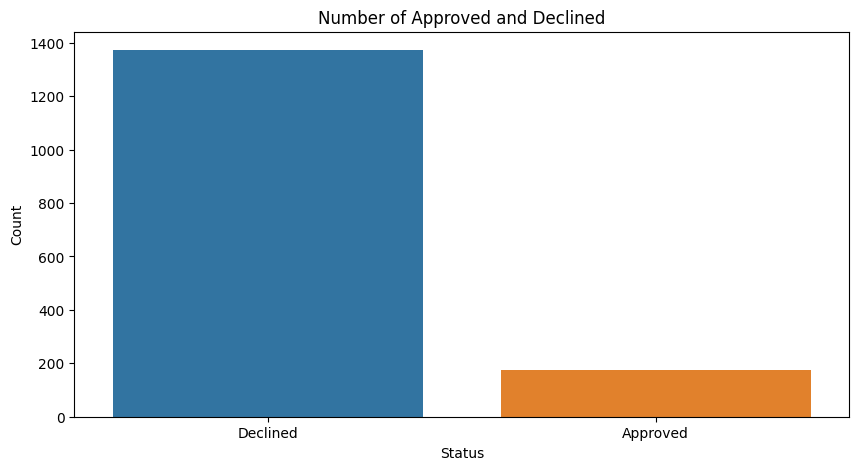

In [10]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df['Status'].value_counts().index, y=df['Approved'].value_counts().values)
plt.title('Number of Approved and Declined')
plt.ylabel('Count');

Heavily skewed towards declined

### Education Distribution

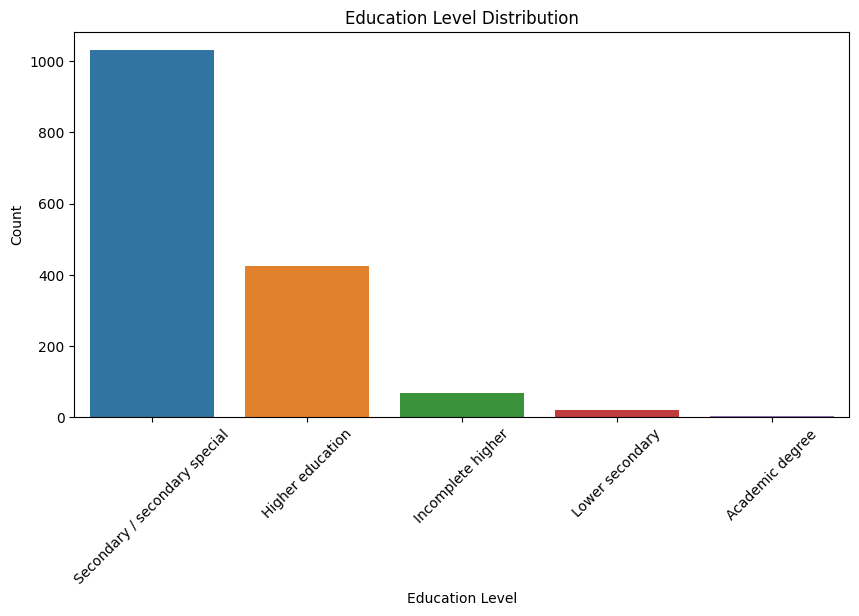

In [11]:
plt.figure(figsize=(10, 5))

eds = df.EDUCATION.value_counts().index
sns.barplot(x=eds, y=df.EDUCATION.value_counts().values)
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Education Level Distribution')
plt.xticks(rotation=45)
plt.show();

### Occupation Type Distribution

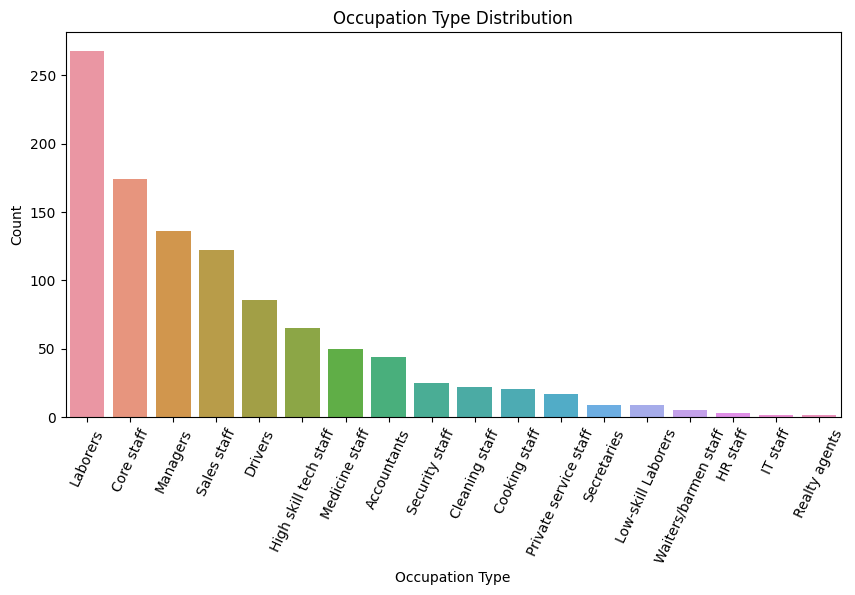

In [12]:
plt.figure(figsize=(10, 5))

occ_types = df.Type_Occupation.value_counts().index
sns.barplot(x=occ_types, y=df.Type_Occupation.value_counts().values)
plt.xlabel('Occupation Type')
plt.ylabel('Count')
plt.title('Occupation Type Distribution')
plt.xticks(rotation=65)
plt.show();

### Income Type Distribution

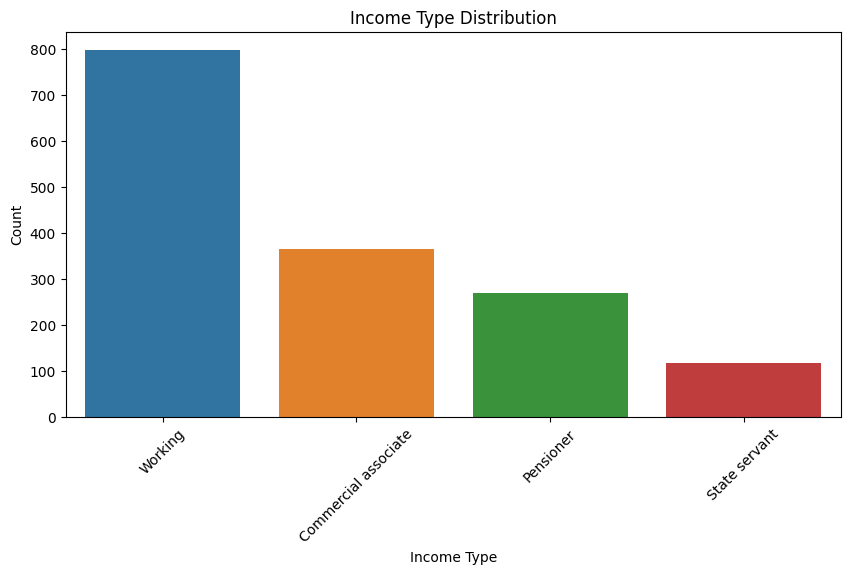

In [13]:
plt.figure(figsize=(10, 5))

occ_types = df.Type_Income.value_counts().index
sns.barplot(x=occ_types, y=df.Type_Income.value_counts().values)
plt.xlabel('Income Type')
plt.ylabel('Count')
plt.title('Income Type Distribution')
plt.xticks(rotation=45)
plt.show()

### Marital Status Distribution

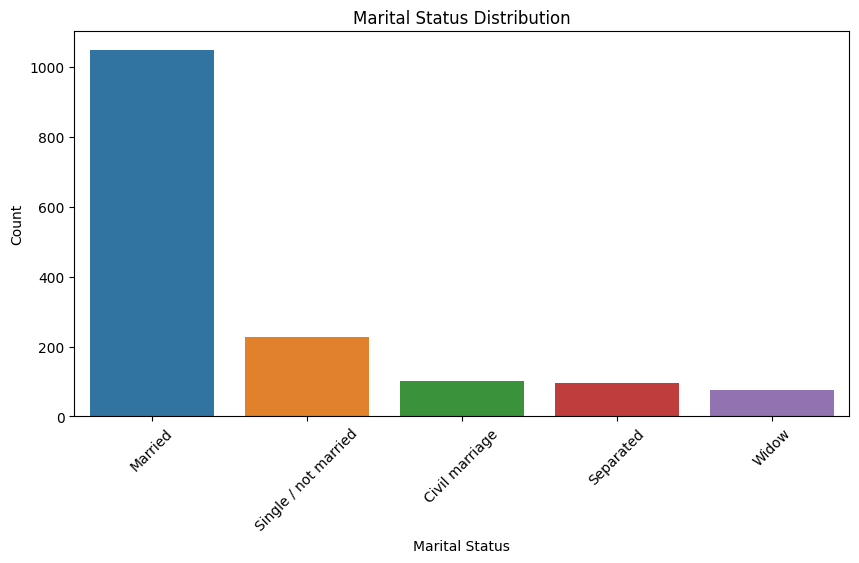

In [14]:
plt.figure(figsize=(10, 5))

marital_types = df.Marital_status.value_counts().index
sns.barplot(x=marital_types, y=df.Marital_status.value_counts().values)
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Marital Status Distribution')
plt.xticks(rotation=45)
plt.show()

### Employed Days Distribution

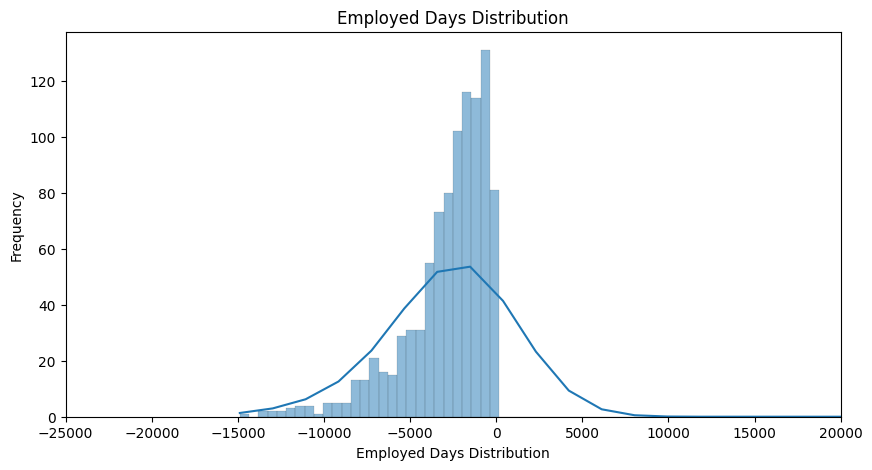

In [15]:
plt.figure(figsize=(10, 5))

emp_days = df.Employed_days.value_counts().index
sns.histplot(x=emp_days, kde=True)
plt.xlabel('Employed Days Distribution')
plt.ylabel('Frequency')
plt.title('Employed Days Distribution')
plt.xlim(-25000, 20000);

Mostly around 5-7 years employment

### Housing Type Distribution

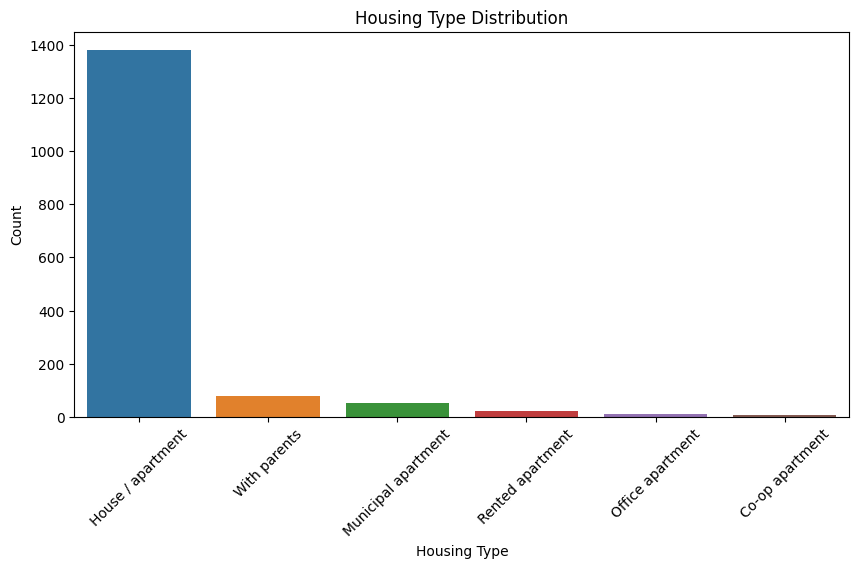

In [16]:
plt.figure(figsize=(10, 5))

housing_types = df.Housing_type.value_counts().index
sns.barplot(x=housing_types, y=df.Housing_type.value_counts().values)
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.title('Housing Type Distribution')
plt.xticks(rotation=45)
plt.show()

## Preprocess Data

### Categorical and Continuous Fields

In [17]:
cats = [
    'GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income',
    'EDUCATION', 'Marital_status', 'Housing_type', 'Mobile_phone',
    'Work_Phone', 'Phone', 'Type_Occupation', 'EMAIL_ID'
]

conts = [
    'CHILDREN', 'Family_Members', 'Annual_income',
    'Age', 'EmployedDaysOnly', 'UnemployedDaysOnly'
]

In [18]:
def proc_data():
    df['Age'] = -df.Birthday_count // 365
    df['EmployedDaysOnly'] = df.Employed_days.apply(lambda x: x if x > 0 else 0)
    df['UnemployedDaysOnly'] = df.Employed_days.apply(lambda x: abs(x) if x < 0 else 0)

    for cat in cats:
        df[cat] = pd.Categorical(df[cat])

    modes = df.mode().iloc[0]
    df.fillna(modes, inplace=True)

proc_data()

## Random Forest Classifier

Given how skewed the classes are, over sampling is needed. Given how small the dataset is, undersampling won't be used.

In [19]:
X, y = df[cats + conts].copy(), df[dep]

X_over, y_over = RandomOverSampler().fit_resample(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_over, y_over, test_size=0.25)

X_train[cats] = X_train[cats].apply(lambda x: x.cat.codes)
X_val[cats] = X_val[cats].apply(lambda x: x.cat.codes)

In [20]:
rf = RandomForestClassifier(100, oob_score=True)
rf.fit(X_train, y_train);

In [21]:
preds = rf.predict(X_val)
mse = mean_absolute_error(preds, y_val)
oob_error = 1 - rf.oob_score_
acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)

print('MSE: ', mse)
print('OOB: ', oob_error)
print('Accuracy: ', acc)
print('F1 Score: ', f1)

MSE:  0.011644832605531296
OOB:  0.013598834385624037
Accuracy:  0.9883551673944687
F1 Score:  0.988235294117647


### Feature Importance

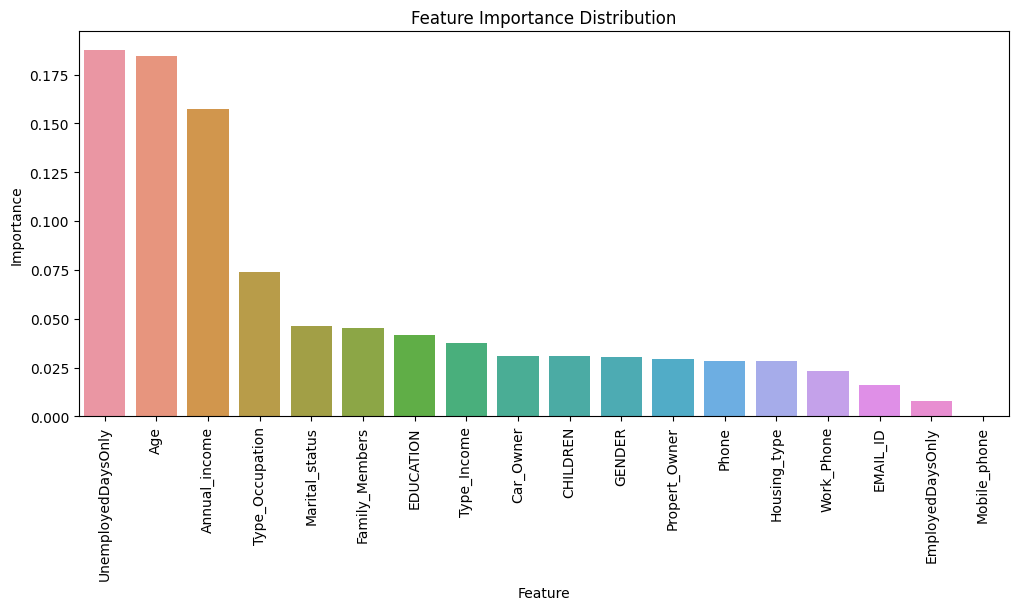

In [22]:
feature_imps = rf.feature_importances_

sorted_indexes = feature_imps.argsort()[::-1]

cols = X_train.columns[sorted_indexes]

plt.figure(figsize=(12, 5))

sns.barplot(x=cols, y=feature_imps[sorted_indexes])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Distribution')
plt.xticks(rotation=90)
plt.show();

### Confusion

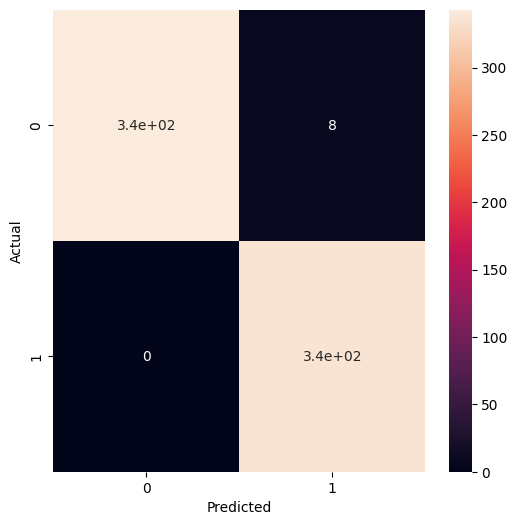

In [23]:
confusion = confusion_matrix(y_val, preds)
plt.figure(figsize=(6,6))
sns.heatmap(confusion, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual");

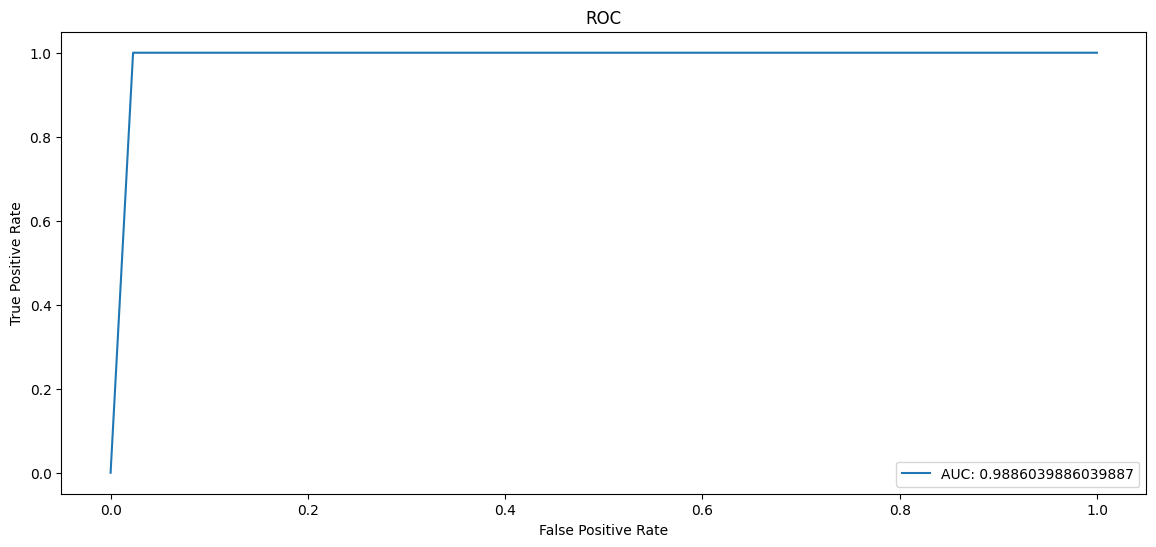

In [24]:
plt.figure(figsize=(14, 6))

fpr, tpr, thresh = roc_curve(y_val, preds)
auc = roc_auc_score(y_val, preds)
plt.plot(fpr, tpr, label="AUC: "+str(auc))

plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=0);

## Results

This was a non-starter without oversampling. Without oversampling, accuracy was deceptively pretty good around 91% but when looking at the confusion matrix and abismal F1 score it was obviously aweful.

I split employed days column into "unemployed" and "employed". It's not surprising looking at the feature importance plot that unemployed days, age and income are the top contributors.

**Final Results:**

| Score | Value |
| :-----   | :--------: |
| ROC AUC | 0.9958 |
| MSE |  0.0044
| OOB | 0.0141
| Accuracy | 0.9956
| F1 Score |  0.9955